## Урок 2. Масштабирование признаков. L1- и L2-регуляризация. Стохастический градиентный спуск
1. Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

2. Модифицировать решение первого задания путем добавления 𝐿2 -регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

3 [опция]. Модернизировать решение задания 2, заменив L2 регуляризацию на L1 регуляризацию.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression as Regression # создаем датасет
import timeit

In [2]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [3]:
class Control_values:
    import numpy as np

    def __init__(self, length):
        self.array_length = length
        self.array = np.zeros(self.array_length)

    def add_value(self, value):
        self.array = np.hstack((self.array[1:], value))


## 1. Сгенерировать датасет при помощи sklearn.datasets.make_regression и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.

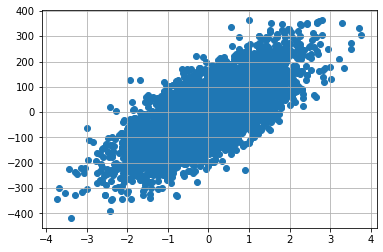

In [4]:
"""make_regression(n_samples=100, n_features=100, *, n_informative=10, n_targets=1, bias=0.0, effective_rank=None, 
tail_strength=0.5, noise=0.0, shuffle=True, coef=False, random_state=None)"""
X, y = Regression(n_samples=5000, n_features=1, noise=80, random_state=17)
plt.scatter(X,y)
plt.grid(True)
plt.show()

In [5]:
X = np.concatenate((np.array([np.ones(len(X))]),X.T),axis=0)

In [6]:
X.T.shape

(5000, 2)

In [7]:
y.shape

(5000,)

In [8]:
error_change = 10**(-15)

### Градиентный спуск

In [9]:
n = X.shape[1]
alpha = 9.39e-2 # 0.1
epochs_number_gd = 2000

W = np.array([1, 0.5])
print(f' Weights - {W}, \n learning rate - {alpha}, \n X size - {X.shape}, \n Y size - {y.shape}')

 Weights - [1.  0.5], 
 learning rate - 0.0939, 
 X size - (2, 5000), 
 Y size - (5000,)


In [10]:
def gradient_descent(X, y, initial_weights, epochs, error_change = 0.0001):
    control_values = Control_values(5)
    err_array = np.array([])
    for i in range(epochs):
        y_pred = np.dot(initial_weights, X)
        err = calc_mse(y, y_pred)
        err_array = np.append(err_array, err)
        initial_weights -= alpha * (1/n * 2 * np.sum(X * (y_pred - y), axis=1))
        control_values.add_value(err)
        if i > 5:
            if abs(np.mean(control_values.array) - err) < error_change:
                final_epoch = i
                final_err = err**0.5
                return y_pred, initial_weights, final_err, final_epoch, err_array
        """if i % 100 == 0:
            print(i, initial_weights, err)"""
    final_epoch = epochs
    final_err = err**0.5
    return y_pred, initial_weights, final_err_gd, final_epoch, err_array

In [11]:
code_to_test = """
y_pred, W_gd, std_err_gd, final_epoch_gd, _ = gradient_descent(X, y, W, epochs_number_gd, error_change)
"""
elapsed_time_gd = timeit.timeit(code_to_test, setup="from __main__ import gradient_descent, X, y, W, epochs_number_gd, error_change", number=10)/10
print(elapsed_time_gd)

0.005641849399999987


In [12]:
y_pred, W_gd, std_err_gd, final_epoch_gd, errors_gd = gradient_descent(X, y, W, epochs_number_gd, error_change)
gd_str = f'Will be enough {final_epoch_gd} iterations, with W - {W_gd} in gradient descent algorithm' if final_epoch_gd < epochs_number_gd else f'To achieve error change less than {error_change}, it is not enougth {final_epoch_gd} iterations, achieved W - {W_gd} in gradient descent algorithm'
print(gd_str)
gd_str = f'Gradient descent algorithm:\n  number epochs - {final_epoch_gd},\n  W - {W_gd},\n  std - {std_err_gd},\n  execution time - {round(elapsed_time_gd,5)}' 

Will be enough 8 iterations, with W - [-2.62021688 81.51697112] in gradient descent algorithm


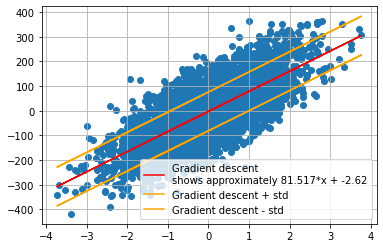

In [13]:
plt.scatter(X[1,:], y)
plt.plot(X[1, :], W_gd[1]*X[1, :] + W_gd[0], color='Red',
         label=f'Gradient descent \nshows approximately {round(W_gd[1],3)}*x + {round(W_gd[0],3)}')
plt.plot(X[1, :], W_gd[1]*X[1, :] + W_gd[0] + std_err_gd, color='Orange', label=f'Gradient descent + std')
plt.plot(X[1, :], W_gd[1]*X[1, :] + W_gd[0] - std_err_gd, color='Orange', label=f'Gradient descent - std')
plt.legend()
plt.grid(True)

### Стохастический градиентный спуск

In [14]:
n = X.shape[1]
alpha = 3e-1 # 0.1
epochs_number = 100000

W = np.array([1, 0.5])
print(f' Weights - {W}, \n learning rate - {alpha}, \n X size - {X.shape}, \n Y size - {y.shape}')

 Weights - [1.  0.5], 
 learning rate - 0.3, 
 X size - (2, 5000), 
 Y size - (5000,)


In [15]:
def stochastic_gradient_descent(X, y, initial_weights, epochs, error_change = 0.001):
    """with error based on full dataset"""
    control_values = Control_values(5)
    err_array = np.array([])
    for i in range(epochs):
        current_error_pos = np.random.randint(0, max(X.shape))
        y_pred = np.dot(initial_weights, X)
        err = calc_mse(y, y_pred)
        err_array = np.append(err_array, err)
        initial_weights -= alpha * (1/n * 2 * X[:, current_error_pos] * (y_pred[current_error_pos] - y[current_error_pos]))
        control_values.add_value(err)
        """if i % 100000 == 0:
            print(i, initial_weights, err)"""
        if i > 5:
            if abs(np.mean(control_values.array) - err) < error_change:
                final_epoch = i
                final_err = err**0.5
                return y_pred, initial_weights, final_err, final_epoch, err_array
    final_err = err**0.5
    final_epoch = epochs
    return y_pred, initial_weights, final_err, final_epoch, err_array

In [16]:
code_to_test = """
y_pred, W_stoch_gd, std_err_stoch_gd, final_epoch_stoch_gd, _ = stochastic_gradient_descent(X, y, W, epochs_number, error_change)
"""
elapsed_time_stoch_gd = timeit.timeit(code_to_test, setup="from __main__ import stochastic_gradient_descent, X, y, W, epochs_number, error_change", number=10)/10
print(elapsed_time_stoch_gd)

13.156584765


In [17]:
y_pred, W_stoch_gd, std_err_stoch_gd, final_epoch_stoch_gd, errors_sgd = stochastic_gradient_descent(X, y, W, epochs_number, error_change)
stoch_str = f'Will be enough {final_epoch_stoch_gd} iterations, with W - {W_stoch_gd} in stochastic gradient descent algorithm' if final_epoch_stoch_gd < epochs_number else f'To achieve error change less than {error_change}, it is not enougth {final_epoch_stoch_gd} iterations, achieved W - {W_stoch_gd} in stochastic gradient descent algorithm'
print(stoch_str)
stoch_str = f'Stochastic gradient descent algorithm:\n  number epochs - {final_epoch_stoch_gd},\n  W - {W_stoch_gd},\n  std - {std_err_stoch_gd},\n  execution time - {round(elapsed_time_stoch_gd,5)}' 

To achieve error change less than 1e-15, it is not enougth 100000 iterations, achieved W - [-1.91568006 80.71592897] in stochastic gradient descent algorithm


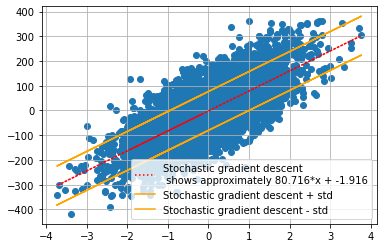

In [18]:
plt.scatter(X[1,:], y)
plt.plot(X[1, :], W_stoch_gd[1]*X[1, :] + W_stoch_gd[0], color='Red', linestyle=':',
         label=f'Stochastic gradient descent\n shows approximately {round(W_stoch_gd[1],3)}*x + {round(W_stoch_gd[0],3)}')
plt.plot(X[1, :], W_stoch_gd[1]*X[1, :] + W_stoch_gd[0] + std_err_stoch_gd, color='Orange', 
         label=f'Stochastic gradient descent + std')
plt.plot(X[1, :], W_stoch_gd[1]*X[1, :] + W_stoch_gd[0] - std_err_stoch_gd, color='Orange', 
         label=f'Stochastic gradient descent - std')
plt.legend()
plt.grid(True)

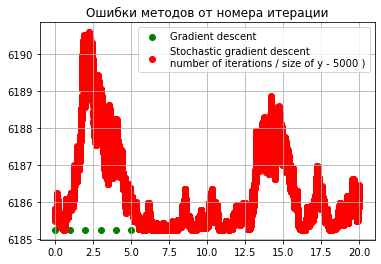

In [19]:
plt.scatter(list(range(len(errors_gd))), errors_gd, color='Green', label=f'Gradient descent')
plt.scatter(np.dot(list(range(len(errors_sgd))),1/len(y)), errors_sgd, color='Red', label=f'Stochastic gradient descent \nnumber of iterations / size of y - {len(y)} )')
plt.legend()

plt.title('Ошибки методов от номера итерации')
plt.grid(True)

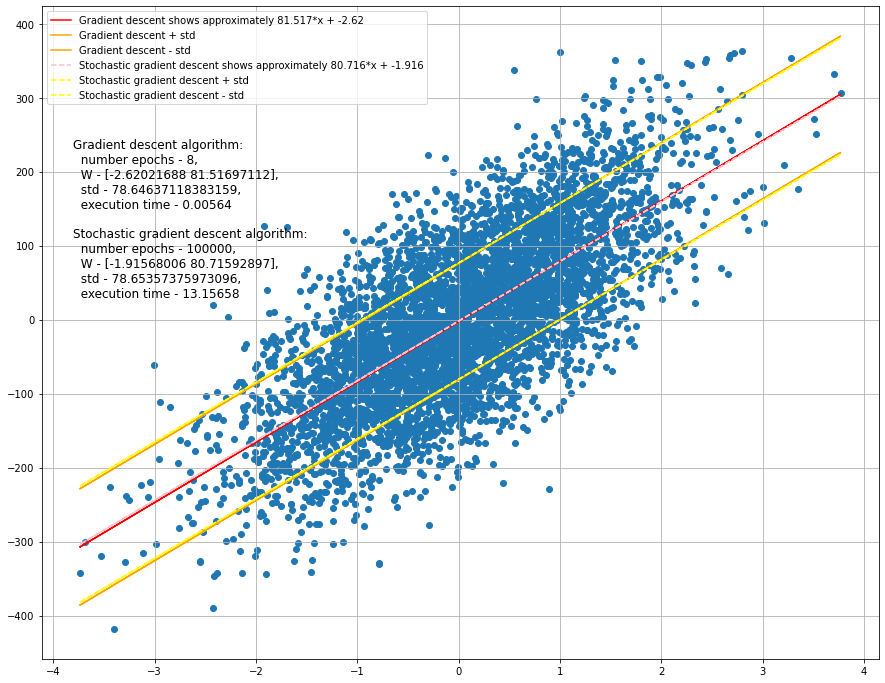

In [20]:
plt.rcParams["figure.figsize"] = (15,12)
plt.scatter(X[1,:], y)
plt.plot(X[1, :], W_gd[1]*X[1, :] + W_gd[0], color='Red',
         label=f'Gradient descent shows approximately {round(W_gd[1],3)}*x + {round(W_gd[0],3)}')
plt.plot(X[1, :], W_gd[1]*X[1, :] + W_gd[0] + std_err_gd, color='Orange', label=f'Gradient descent + std')
plt.plot(X[1, :], W_gd[1]*X[1, :] + W_gd[0] - std_err_gd, color='Orange', label=f'Gradient descent - std')
plt.plot(X[1, :], W_stoch_gd[1]*X[1, :] + W_stoch_gd[0], color='pink', linestyle='--',
         label=f'Stochastic gradient descent shows approximately {round(W_stoch_gd[1],3)}*x + {round(W_stoch_gd[0],3)}')
plt.plot(X[1, :], W_stoch_gd[1]*X[1, :] + W_stoch_gd[0] + std_err_stoch_gd, color='yellow', linestyle='--',
         label=f'Stochastic gradient descent + std')
plt.plot(X[1, :], W_stoch_gd[1]*X[1, :] + W_stoch_gd[0] - std_err_stoch_gd, color='yellow', linestyle='--',
         label=f'Stochastic gradient descent - std')
plt.text(-3.8, 150, gd_str, fontsize = 12)
plt.text(-3.8, 30, stoch_str, fontsize = 12)
plt.legend()
plt.grid(True)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

### Стохастический метод более нестабилен и требует существенно больше итераций, но можно использовать большую скорость обучения. Если за каждую итерацию помимо нахождения ошибки будет много других операций, то стохастический метод может оказаться медленнее.
Если учесть размер векторов/матриц, то сложность алгоритма для стохастического метода заметно снижается.

## 2. Модифицировать решение первого задания путем добавления 𝐿2 -регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

In [21]:
#n = X.shape[1]
#alpha = 9.39e-2 # 0.1
#epochs_number_gd = 2000
lambda_ = 10**(-9)
W = np.array([1, 0.5])
print(f' Weights - {W}, \n learning rate - {alpha}, \n X size - {X.shape}, \n Y size - {y.shape}')

 Weights - [1.  0.5], 
 learning rate - 0.3, 
 X size - (2, 5000), 
 Y size - (5000,)


In [22]:
"""def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)**0.5
    return err"""

'def calc_mse(y, y_pred):\n    err = np.mean((y - y_pred)**2)**0.5\n    return err'

In [23]:
def gradient_descent(X, y, initial_weights, epochs, error_change = 0.0001, lambda_ = 0.000001):
    control_values = Control_values(5)
    err_array = np.array([])
    for i in range(epochs):
        y_pred = np.dot(initial_weights, X)
        err = calc_mse(y, y_pred)
        err_array = np.append(err_array, err)
        initial_weights -= alpha * (1/n * 2 * np.sum(X * (y_pred - y), axis=1) + lambda_ * abs(W))
        control_values.add_value(err)
        if i > 5:
            if abs(np.mean(control_values.array) - err) < error_change:
                final_epoch = i
                final_err = err**0.5
                return y_pred, initial_weights, final_err, final_epoch, err_array
        """if i % 100 == 0:
            print(i, initial_weights, err)"""
    final_epoch = epochs
    final_err = err**0.5
    return y_pred, initial_weights, final_err, final_epoch, err_array

In [24]:
code_to_test = """
y_pred_L1, W_gd_L1, std_err_gd_L1, final_epoch_gd_L1, _ = gradient_descent(X, y, W, epochs_number_gd, error_change)
"""
elapsed_time_gd_L1 = timeit.timeit(code_to_test, setup="from __main__ import gradient_descent, X, y, W, epochs_number_gd, error_change", number=10)/10
print(elapsed_time_gd_L1)

0.0024836203000006664


In [25]:
y_pred_L1, W_gd_L1, std_err_gd_L1, final_epoch_gd_L1, errors_gd_L1 = gradient_descent(X, y, W, epochs_number_gd, error_change)
gd_str_L1 = f'Will be enough {final_epoch_gd_L1} iterations, with W - {W_gd_L1} in gradient descent algorithm' if final_epoch_gd_L1 < epochs_number_gd else f'To achieve error change less than {error_change}, it is not enougth {final_epoch_gd_L1} iterations, achieved W - {W_gd_L1} in gradient descent algorithm'
print(gd_str_L1)
gd_str_L1 = f'Gradient descent L1 algorithm:\n  number epochs - {final_epoch_gd_L1},\n  W - {W_gd_L1},\n  std - {std_err_gd_L1},\n  execution time - {round(elapsed_time_gd_L1,5)}' 

Will be enough 6 iterations, with W - [-2.62021755 81.51693115] in gradient descent algorithm


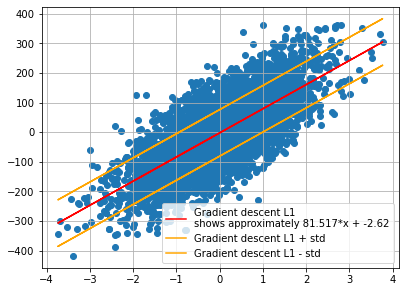

In [26]:
plt.scatter(X[1,:], y)
plt.plot(X[1, :], W_gd_L1[1]*X[1, :] + W_gd_L1[0], color='Red',
         label=f'Gradient descent L1\nshows approximately {round(W_gd_L1[1],3)}*x + {round(W_gd_L1[0],3)}')
plt.plot(X[1, :], W_gd_L1[1]*X[1, :] + W_gd_L1[0] + std_err_gd_L1, color='Orange', label=f'Gradient descent L1 + std')
plt.plot(X[1, :], W_gd_L1[1]*X[1, :] + W_gd_L1[0] - std_err_gd_L1, color='Orange', label=f'Gradient descent L1 - std')
plt.legend()
plt.grid(True)

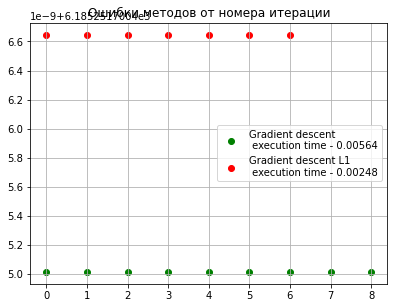

In [27]:
plt.scatter(list(range(len(errors_gd))), errors_gd, color='Green', label=f'Gradient descent \n execution time - {round(elapsed_time_gd,5)}')
plt.scatter(list(range(len(errors_gd_L1))), errors_gd_L1, color='Red', label=f'Gradient descent L1 \n execution time - {round(elapsed_time_gd_L1,5)}')
plt.legend()

plt.title('Ошибки методов от номера итерации')
plt.grid(True)

## 3. Модернизировать решение задания 2, заменив L2 регуляризацию на L1 регуляризацию.

In [28]:
#n = X.shape[1]
#alpha = 9.39e-2 # 0.1
#epochs_number_gd = 2000
lambda_1 = 0
lambda_2 = 10**(-9)
W = np.array([1, 0.5])
print(f' Weights - {W}, \n learning rate - {alpha}, \n X size - {X.shape}, \n Y size - {y.shape}')

 Weights - [1.  0.5], 
 learning rate - 0.3, 
 X size - (2, 5000), 
 Y size - (5000,)


In [29]:
def gradient_descent_elastic(X, y, initial_weights, epochs, error_change = 0.0001, lambda_1 = 0.000001, lambda_2 = 0.000001):
    control_values = Control_values(5)
    err_array = np.array([])
    for i in range(epochs):
        y_pred = np.dot(initial_weights, X)
        err = calc_mse(y, y_pred)
        err_array = np.append(err_array, err)
        initial_weights -= alpha * (1/n * 2 * np.sum(X * (y_pred - y), axis=1) + lambda_2 * abs(W) + lambda_2 * W * W)
        control_values.add_value(err)
        if i > 5:
            if abs(np.mean(control_values.array) - err) < error_change:
                final_epoch = i
                final_err = err**0.5
                return y_pred, initial_weights, final_err, final_epoch, err_array
        """if i % 100 == 0:
            print(i, initial_weights, err)"""
    final_epoch = epochs
    final_err = err**0.5
    return y_pred, initial_weights, final_err_gd, final_epoch, err_array

In [30]:
code_to_test = """
y_pred_elastic, W_gd_elastic, std_err_gd_elastic, final_epoch_gd_elastic, _ = gradient_descent(X, y, W, epochs_number_gd, error_change, lambda_1)
"""
elapsed_time_gd_elastic = timeit.timeit(code_to_test, setup="from __main__ import gradient_descent, X, y, W, epochs_number_gd, error_change, lambda_1", number=10)/10
print(elapsed_time_gd_elastic)

0.0025992631999997686


In [31]:
y_pred_elastic, W_gd_elastic, std_err_gd_elastic, final_epoch_gd_elastic, errors_gd_elastic = gradient_descent(X, y, W, epochs_number_gd, error_change, lambda_1)
gd_str_elastic = f'Will be enough {final_epoch_gd_elastic} iterations, with W - {W_gd_elastic} in gradient descent algorithm' if final_epoch_gd_elastic < epochs_number_gd else f'To achieve error change less than {error_change}, it is not enougth {final_epoch_gd_elastic} iterations, achieved W - {W_gd_elastic} in gradient descent algorithm'
print(gd_str_elastic)
gd_str_elastic = f'Gradient descent elastic algorithm:\n  number epochs - {final_epoch_gd_elastic},\n  W - {W_gd_elastic},\n  std - {std_err_gd_elastic},\n  execution time - {round(elapsed_time_gd_elastic,5)}' 

Will be enough 6 iterations, with W - [-2.62021688 81.51697112] in gradient descent algorithm


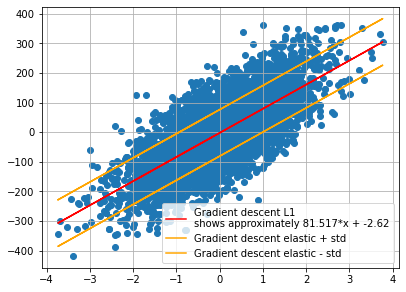

In [32]:
plt.scatter(X[1,:], y)
plt.plot(X[1, :], W_gd_elastic[1]*X[1, :] + W_gd_elastic[0], color='Red',
         label=f'Gradient descent L1\nshows approximately {round(W_gd_elastic[1],3)}*x + {round(W_gd_elastic[0],3)}')
plt.plot(X[1, :], W_gd_elastic[1]*X[1, :] + W_gd_elastic[0] + std_err_gd_elastic, color='Orange', label=f'Gradient descent elastic + std')
plt.plot(X[1, :], W_gd_elastic[1]*X[1, :] + W_gd_elastic[0] - std_err_gd_elastic, color='Orange', label=f'Gradient descent elastic - std')
plt.legend()
plt.grid(True)

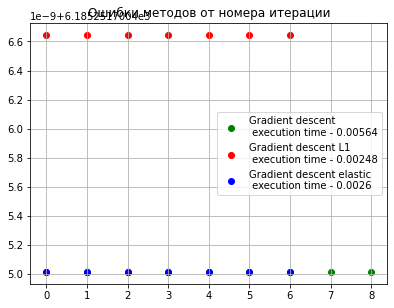

In [33]:
plt.scatter(list(range(len(errors_gd[:30]))), errors_gd[:30], color='Green', label=f'Gradient descent \n execution time - {round(elapsed_time_gd,5)}')
plt.scatter(list(range(len(errors_gd_L1[:30]))), errors_gd_L1[:30], color='Red', label=f'Gradient descent L1 \n execution time - {round(elapsed_time_gd_L1,5)}')
plt.scatter(list(range(len(errors_gd_elastic[:30]))), errors_gd_elastic[:30], color='Blue', label=f'Gradient descent elastic \n execution time - {round(elapsed_time_gd_elastic,5)}')

plt.legend()

plt.title('Ошибки методов от номера итерации')
plt.grid(True)

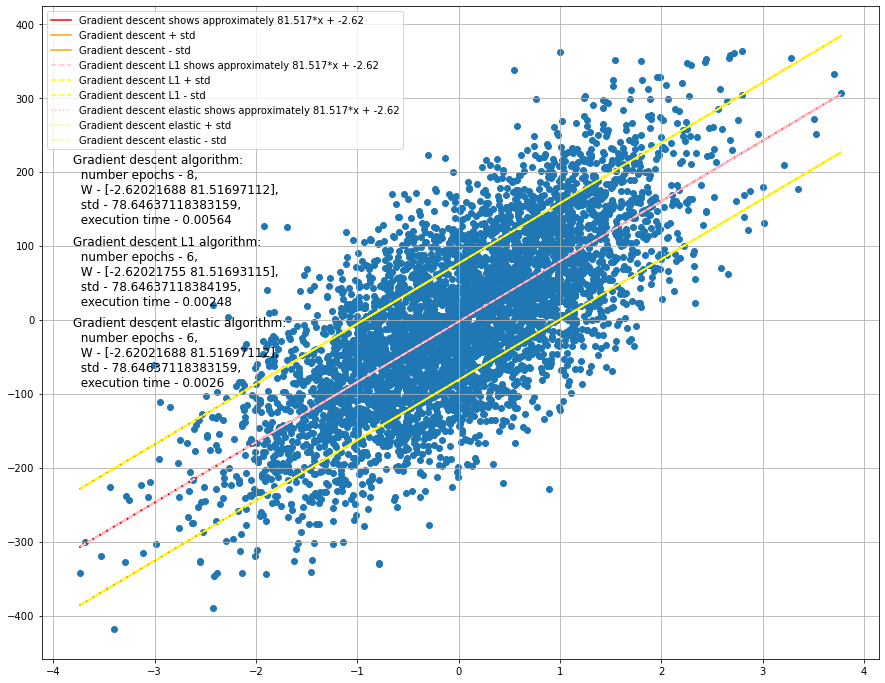

In [34]:
plt.rcParams["figure.figsize"] = (15,12)
plt.scatter(X[1,:], y)
plt.plot(X[1, :], W_gd[1]*X[1, :] + W_gd[0], color='Red',
         label=f'Gradient descent shows approximately {round(W_gd[1],3)}*x + {round(W_gd[0],3)}')
plt.plot(X[1, :], W_gd[1]*X[1, :] + W_gd[0] + std_err_gd, color='Orange', label=f'Gradient descent + std')
plt.plot(X[1, :], W_gd[1]*X[1, :] + W_gd[0] - std_err_gd, color='Orange', label=f'Gradient descent - std')

plt.plot(X[1, :], W_gd_L1[1]*X[1, :] + W_gd_L1[0], color='pink', linestyle='--',
         label=f'Gradient descent L1 shows approximately {round(W_gd_L1[1],3)}*x + {round(W_gd_L1[0],3)}')
plt.plot(X[1, :], W_gd_L1[1]*X[1, :] + W_gd_L1[0] + std_err_gd_L1, color='yellow', linestyle='--',
         label=f'Gradient descent L1 + std')
plt.plot(X[1, :], W_gd_L1[1]*X[1, :] + W_gd_L1[0] - std_err_gd_L1, color='yellow', linestyle='--',
         label=f'Gradient descent L1 - std')

plt.plot(X[1, :], W_gd_elastic[1]*X[1, :] + W_gd_elastic[0], color='pink', linestyle=':',
         label=f'Gradient descent elastic shows approximately {round(W_gd_elastic[1],3)}*x + {round(W_gd_elastic[0],3)}')
plt.plot(X[1, :], W_gd_elastic[1]*X[1, :] + W_gd_elastic[0] + std_err_gd_elastic, color='yellow', linestyle=':',
         label=f'Gradient descent elastic + std')
plt.plot(X[1, :], W_gd_elastic[1]*X[1, :] + W_gd_elastic[0] - std_err_gd_elastic, color='yellow', linestyle=':',
         label=f'Gradient descent elastic - std')

plt.text(-3.8, 130, gd_str, fontsize = 12)
plt.text(-3.8, 20, gd_str_L1, fontsize = 12)
plt.text(-3.8, -90, gd_str_elastic, fontsize = 12)
plt.legend()
plt.grid(True)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]